In [ ]:
import numpy as np
import pandas as pd
import plotly as plt
import plotly.express as px
import scipy.stats
import tensorflow as tf

# import tensorflow_addons as tfa
import tensorflow_probability as tfp
import umap as umap

# import jax

tfkl = tf.keras.layers
tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors
tfko = tf.keras.optimizers
tfpl = tfp.layers

# Ripe rimu in 2002 and 2019 on Whenua Hou, 2016 and 2019 on Anchor

# TODO:! Sex ratio of offspring!

In [ ]:
[tf.__version__, tfp.__version__]

In [ ]:
fertility = pd.read_csv("fertility_confirmed_father.csv")
fertility.columns

In [ ]:
px.histogram(fertility.groupby("bird").agg("size"))

In [ ]:
px.histogram(fertility.groupby("Father").agg("size"))

In [ ]:
fertility.columns

In [ ]:
fertility

In [ ]:
x = fertility[
    [
        "bird",
        "Father",
        "year",
        "Island",
        "clutch size",
        "infertile eggs",
        "fertile eggs",
        "dead embryo",
        "Very early dead embryo <5 days (microscopic)",
        "Very early dead embryo not determined",
        "early dead embryo 5-10d",
        "mid DE 11-20d",
        "Late DE 21-30d",
        # "year_weight",
        # "year_age",
    ]
].copy()
# x["ratio"] = 1 - (x["Very early dead embryo <5 days (microscopic)"]/x["clutch size"])
# x["ratio"] = 1 - (x["dead embryo"] / x["clutch size"])
# x['ratio'] = 1 - (x['Very early dead embryo <5 days (microscopic)'] / x['clutch size'])
x["ratio"] = 1 - (x["infertile eggs"] / x["clutch size"])
# x['ratio'] = x['clutch size']
x

In [ ]:
x = x.dropna(subset=["ratio"])

In [ ]:
x.year.unique()

In [ ]:
x[x["bird"] == "Esperance"]

In [ ]:
x = x.reset_index()
px.histogram(x["ratio"])

In [ ]:
x

In [ ]:
x.groupby(["bird", "Father"]).size()[x.groupby(["bird", "Father"]).size() > 1].std()

In [ ]:
x.groupby(["bird", "Father"]).size()[x.groupby(["bird", "Father"]).size() > 1].std()

In [ ]:
x["ratio"].std()

In [ ]:
x[x["bird"] == "Zephyr"]

## Model

In [ ]:
def make_categorical(df, column):
    df[column] = df[column].astype("category")
    df[column + "_code"] = df[column].cat.codes
    df[column + "_code"] = df[column + "_code"].astype("int32")
    return df


labels = x[["ratio"]].astype(np.float32).values.flatten()


def target_log_prob_fn(*args):
    return formula.log_prob(*args, output=labels)


Root = tfd.JointDistributionCoroutine.Root  # Convenient alias.

x = make_categorical(x, "bird")
x = make_categorical(x, "Father")

n_islands = x["Island"].nunique()
n_years = x["year"].nunique()
n_birds = x["bird"].nunique()
n_fathers = x["Father"].nunique()


def make_formula(birds, fathers, n_birds, n_fathers):
    print("N Birds:" + str(n_birds))
    print("N Fathers:" + str(n_fathers))
    print(birds)
    print(fathers)

    def model():
        bird_prior = yield Root(
            tfd.Normal(loc=tf.ones(n_birds), scale=tf.ones(n_birds), name="mother")
        )
        father_prior = yield Root(
            tfd.Normal(loc=tf.ones(n_fathers), scale=tf.ones(n_fathers), name="father")
        )

        # bird_scale_prior = yield tfd.Normal(loc=tf.ones(n_birds), scale=1e-2+tf.ones(n_birds), name="mother_scale")
        # father_scale_prior = yield tfd.Normal(loc=tf.ones(n_fathers), scale=1e-2+tf.ones(n_fathers), name="father_scale")
        output_scale = yield tfd.Normal(loc=1.0, scale=1.0, name="output_scale")

        intercept = yield tfd.Normal(loc=np.mean(labels), scale=0.05, name="intercept")

        bird_effect = tf.gather(bird_prior, birds, axis=-1)
        father_effect = tf.gather(father_prior, fathers, axis=-1)

        # bird_scale = tf.gather(bird_scale_prior, birds, axis=-1)
        # father_scale = tf.gather(father_scale_prior, fathers, axis=-1)

        y = intercept + bird_effect * father_effect

        # scale = tf.math.sigmoid(tf.math.minimum(bird_scale, father_scale))
        scale = tf.math.sigmoid(output_scale)

        # Shared scale gets to ~62 loss but heritability is .205
        yield tfd.Normal(
            y,
            scale=1e-8 + scale,
            allow_nan_stats=False,
            name="output",
            validate_args=True,
        )

    return model, tfd.JointDistributionCoroutineAutoBatched(
        model, use_vectorized_map=False, validate_args=True
    )


model, formula = make_formula(
    x["bird_code"].to_numpy(),
    x["Father_code"].to_numpy(),
    n_birds,
    n_fathers,
)

formula.sample_distributions()

N Birds:48
N Fathers:37
[40 22 10 32 34 39 39 39 39 23 31  1 46  1 45  7 10 10  1 23  2  5 13  2
 23 16 23 32 16 22 27 34 39 20 21 26 38 43 42 45  0 28 13 13 47  0 47 35
 47 47 47 28 47 16 17 40  0 31 41 15 19 26 44 14 44  5 34  4 32  8 22 44
 21 40 36 45  9  5 12 25  7 39 25 23  7 32  7 27 10  7 13 18 25 11  0  2
 25 14 24 33 41 43  6 21 29 29  3  9 38 22 27 30  0 11 36 45 36 37  8 10
 32 23]
[ 0  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8
  8  8  8  8  8  9  9 10 11 12 13 13 13 13 13 13 13 15 15 16 16 16 16 17
 17 18 19 19 19 20 20 20 21 22 23 24 24 24 24 25 26 27 27 27 27 28 28 28
 29 30 30 30 30 30 31 31 32 32 33 33 33 34 34 34 35 35 35 35 35 35 36 36
 36 14]


(StructTuple(
   mother=<tfp.distributions.Normal 'JointDistributionCoroutineAutoBatched_sample_distributions_mother' batch_shape=[48] event_shape=[] dtype=float32>,
   father=<tfp.distributions.Normal 'JointDistributionCoroutineAutoBatched_sample_distributions_father' batch_shape=[37] event_shape=[] dtype=float32>,
   output_scale=<tfp.distributions.Normal 'JointDistributionCoroutineAutoBatched_sample_distributions_output_scale' batch_shape=[] event_shape=[] dtype=float32>,
   intercept=<tfp.distributions.Normal 'JointDistributionCoroutineAutoBatched_sample_distributions_intercept' batch_shape=[] event_shape=[] dtype=float32>,
   output=<tfp.distributions.Normal 'JointDistributionCoroutineAutoBatched_sample_distributions_output' batch_shape=[122] event_shape=[] dtype=float32>
 ),
 StructTuple(
   mother=<tf.Tensor: shape=(48,), dtype=float32, numpy=
     array([ 1.5083804 , -0.8581549 ,  0.94168067,  2.3956828 ,  1.7009537 ,
             1.2478446 ,  0.5599596 ,  0.27987075,  0.514274

In [ ]:
_init_loc = lambda shape=(): tf.Variable(
    tf.random.uniform(shape, minval=0.0, maxval=3.0)
)
_init_scale = lambda shape=(): tfp.util.TransformedVariable(
    initial_value=tf.random.uniform(shape, minval=0.01, maxval=1.0),
    bijector=tfb.Softplus(hinge_softness=1e-8),
)


def gen_posterior():
    surrogate_part = [
        tfd.Normal(_init_loc([n_birds]), _init_scale([n_birds])),  # bird / mother
        tfd.Normal(_init_loc([n_fathers]), _init_scale([n_fathers])),  # father
        # tfd.Normal(_init_loc([n_birds]), _init_scale([n_birds])),  # bird / mother scale
        # tfd.Normal(_init_loc([n_fathers]), _init_scale([n_fathers])),  # father scale
        tfd.Normal(_init_loc(), _init_scale()),
        tfd.Normal(_init_loc(), _init_scale()),  # Intercept
    ]
    return surrogate_part


surrogate = tfd.JointDistributionSequentialAutoBatched(
    gen_posterior(), use_vectorized_map=False
)

In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    # formula.log_prob,
    surrogate,
    sample_size=122,
    optimizer=tf.optimizers.Adam(learning_rate=5e-5),
    num_steps=8192 * 32,
    seed=None,
)

In [ ]:
px.scatter(losses[:-1000])

In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    # formula.log_prob,
    surrogate,
    sample_size=122,
    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
    num_steps=8192 * 16,
    seed=None,
)

In [ ]:
px.scatter(losses)

In [ ]:
losses1 = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    # formula.log_prob,
    surrogate,
    sample_size=122,
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    num_steps=8192 * 8,
)

In [ ]:
px.scatter(losses1)

In [ ]:
losses2 = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate,
    sample_size=122,
    optimizer=tf.optimizers.Adam(learning_rate=1e-7),
    num_steps=8192 * 8,
)

In [ ]:
px.scatter(losses2)

In [ ]:
np.mean(losses2)

In [ ]:
(
    mother_,
    father_,
    output_scale_,
    intercept_,
), _ = surrogate.sample_distributions()

In [ ]:
[np.mean(output_scale_.sample(10000)), np.std(output_scale_.sample(10000))]

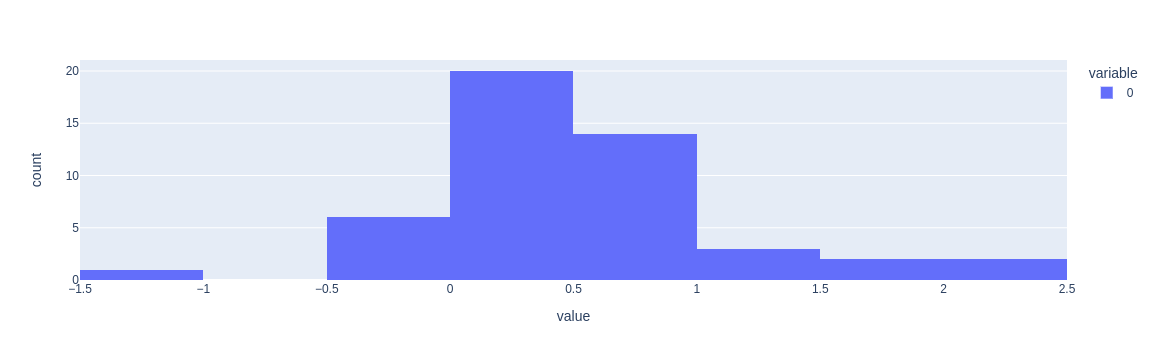

In [ ]:
px.histogram(mother_.mean())

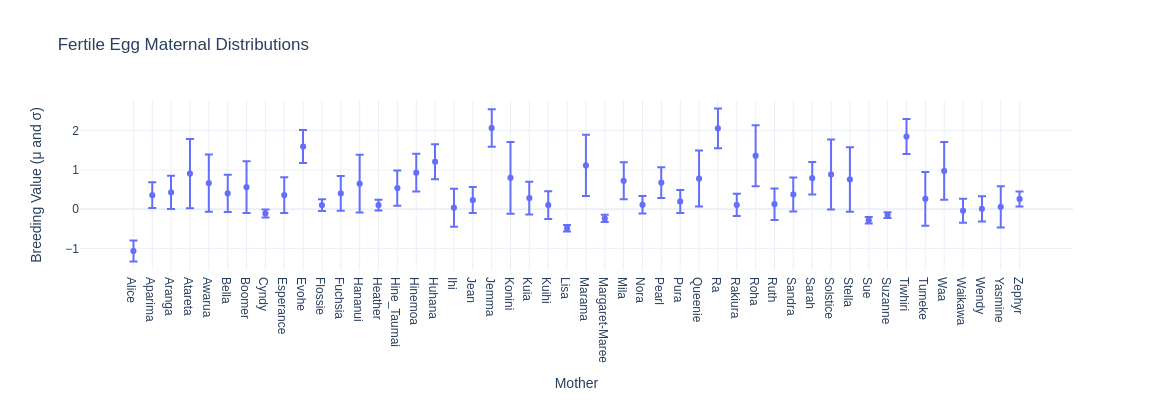

In [199]:
bird_labels = list(
    np.unique(x[["bird", "bird_code"]].sort_values(by="bird_code")["bird"].tolist())
)

fig = px.scatter(
    y=mother_.mean(),
    x=bird_labels,
    error_y=mother_.stddev(),
    template="plotly_white",
    labels={"x": "Mother", "y": "Breeding Value (μ and σ)"},
    title="Fertile Egg Maternal Distributions",
    height=400,
    width=1200,
)

fig.write_image("figures/fertile_egg_maternal_distribution.jpeg")

fig

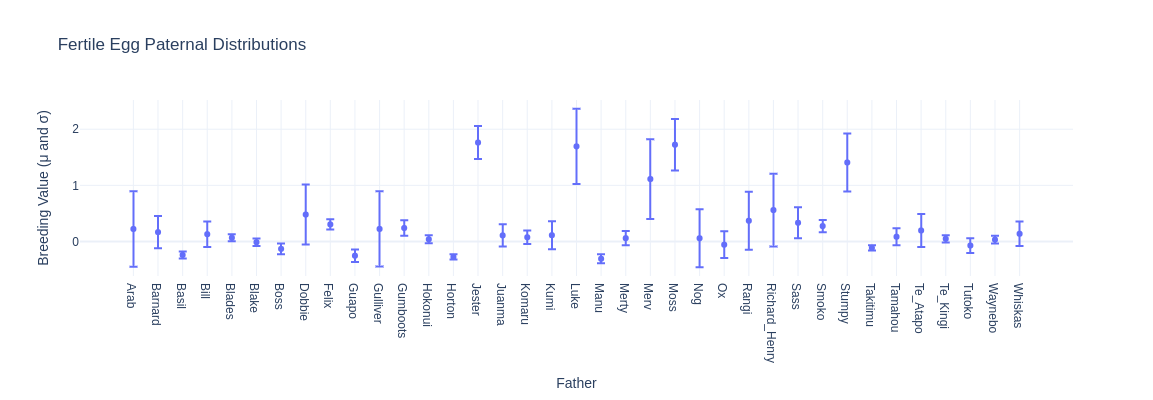

In [200]:
bird_labels = list(
    np.unique(x[["Father", "Father_code"]].sort_values(by="Father_code")["Father"].tolist())
)

fig = px.scatter(
    y=father_.mean(),
    x=bird_labels,
    error_y=father_.stddev(),
    template="plotly_white",
    labels={"x": "Father", "y": "Breeding Value (μ and σ)"},
    title="Fertile Egg Paternal Distributions",
    height=400,
    width=1200,
)

fig.write_image("figures/fertile_egg_paternal_distribution.jpeg")

fig

In [ ]:
px.histogram(mother_.stddev())

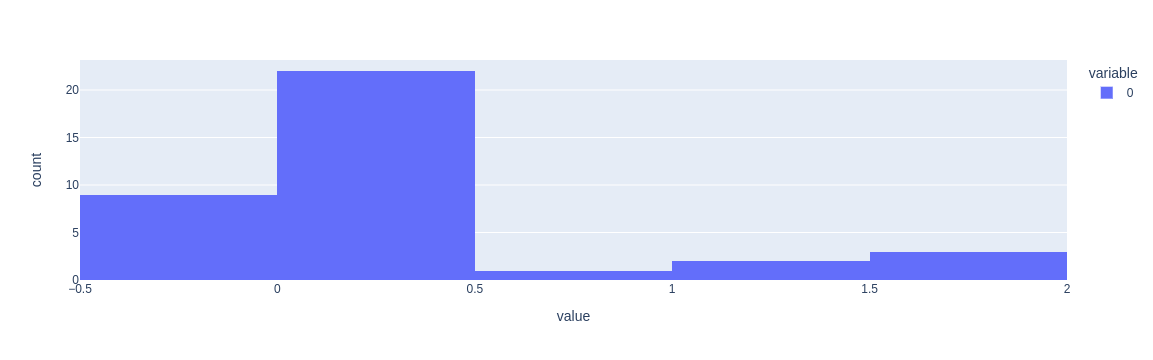

In [ ]:
px.histogram(father_.mean())

In [ ]:
px.histogram(father_.stddev())

In [ ]:
phenos = dict()
fathers = dict()
mothers = dict()

# Have to fix because some columns are dropped

for i, row in x.iterrows():
    phenos[row["Father"]] = father_.mean()[row["Father_code"]].numpy()
    fathers[row["Father"]] = father_.mean()[row["Father_code"]].numpy()
    phenos[row["bird"]] = mother_.mean()[row["bird_code"]].numpy()
    mothers[row["bird"]] = mother_.mean()[row["bird_code"]].numpy()

In [ ]:
# pheno = "SurvivingEmbryos"
# pheno = "VEDSurvivingEmbryos"
pheno = ("FertileEggs",)

In [ ]:
phenos = pd.DataFrame.from_dict(phenos, columns=[pheno], orient="index")

In [ ]:
# phenos.to_csv("surviving_embryos.tsv", sep="\t")
# phenos.to_csv("VEDSurvivingEmbryos.tsv", sep="\t")
phenos.to_csv("FertileEggs_8Aug.tsv", sep="\t")

In [ ]:
# e2 = pd.read_csv("embryo_survival2.tsv", sep="\t", skiprows=0)
# e1 = pd.read_csv("embryo_survival.tsv", sep="\t", skiprows=2)
# e3 = phenos

In [ ]:
phenos

In [ ]:
# np.corrcoef(e1['SurvivingEmbryos'], e2['SurvivingEmbryos'])

In [ ]:
# np.corrcoef(e1['SurvivingEmbryos'], e3['SurvivingEmbryos'])

In [ ]:
# np.corrcoef(e2['SurvivingEmbryos'], e3['SurvivingEmbryos'])

In [ ]:
# df = pd.read_csv("FertileEggs_8Aug.tsv", sep="\t")
# df.insert(0, "#FID", "0")
# df.to_csv(
#    "/home/josephguhlin/software/gcta_1.93.2beta/fertile_eggs_8Aug",
#    sep="\t",
#    index=False,
#    header=None,
# )

In [ ]:
# hibayes Format
fam = pd.read_csv("plink2.fam", sep="\t", header=None)

birds = list()

for i, row in fam.iterrows():
    birds.append(row[1])

with open("fertile_eggs_bayes_format_9Aug.txt", "w") as writer:
    writer.write("vals\n")
    for bird in birds:
        if bird in phenos.index:
            writer.write(str(float(phenos.loc[bird]["FertileEggs"])))
            writer.write("\n")
        else:
            writer.write("-9\n")